Known:
- calcualted effective area is same as paper
- calculated gamma is same as paper for wavelength 1550nm
- exact same source is used for the linear refractive index

Issue:
- calculated GVD and spectrum doesn't match at long wavelength side -> need more step/ resolution ?? Incorrect neff?? 

Note:
- Tried higher resolution - no improvement
- fix refractive index for high wavelength of SI3N4
- check mode profile in long wavelength side

https://iopscience.iop.org/article/10.1088/1555-6611/aaf63d 
H Ahmad et al 2019 Laser Phys. 29 025301

First, construct the geometry of the waveguide and create a mesh. Then generate the effective refractive index and effective mode area of the waveguide using femwell.

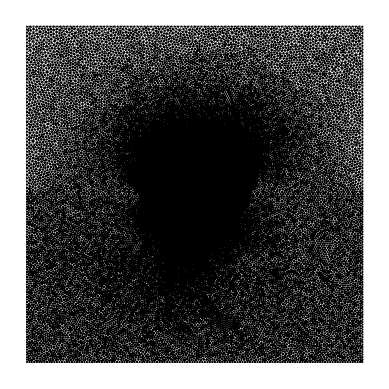

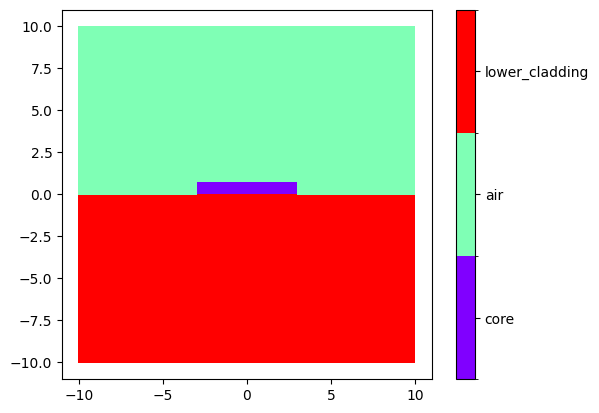

In [5]:
from femwell.visualization import plot_domains
from skfem.io import from_meshio
import shapely
import matplotlib.pyplot as plt
from refractive_index import n_MgF2, n_Si3N4, n_Air
from collections import OrderedDict
from femwell.mesh import mesh_from_OrderedDict
import numpy as np

# waveguide parameters
width = 6  # um
height = 0.8  # um
thickness = 0.8  # um

n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

wavelength_range = [310, 5500]
wavelegnth_step = 100  #  steps

n_core = n_Si3N4
n_lower_cladding = n_MgF2
n_air = n_Air

# Construct waveguide geometry
core = shapely.geometry.box(-width / 2, 0, +width / 2, height)
lower_cladding = shapely.geometry.box(-10, -10, 10, 0)
air = shapely.geometry.box(-10, 0, 10, 10)
polygons = OrderedDict(
    core=core,
    lower_cladding=lower_cladding,
    air= air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.04, "distance": 0.2},
                   lower_cladding={"resolution": 0.15, "distance": 0.5},
                   air={"resolution": 0.2, "distance": 1})

n_dict = {"core": n_core, "lower_cladding": n_lower_cladding, "air_cladding": n_air, "air": n_air}

# Calculate dispersion and gamma
mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions))
mesh.draw().show()
plot_domains(mesh)
plt.show()

Plot the effective mode area and gamma to see if we can reproduce the result in the paper.

0.32008239998777804


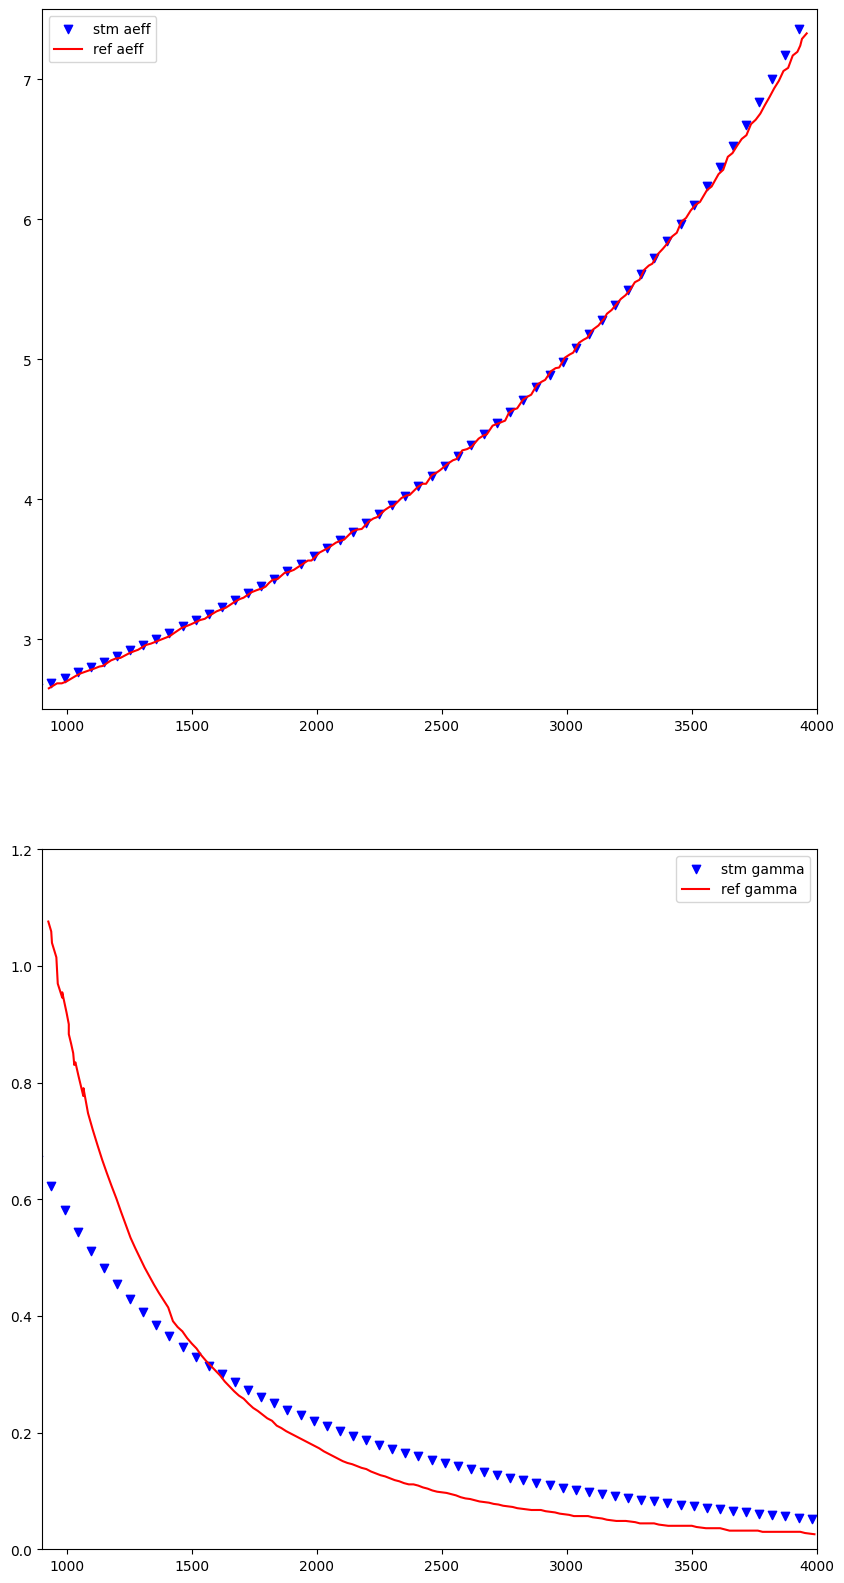

Gamma is 0.3199467733223173/W/m at pump wavelength(1.55um), and the value from paper is 0.32/W/m


In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

data = np.load("data_h_0.8_w_6.npz")
wls = data['wls']
c_mks = 299792458.0
n2 = 2.5e-19
pulseWL = 1550
aeff_list = data['aeff_list']
aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma


gamma_list = list(map(gamma_function, wls))
gamma_interp = scipy.interpolate.interp1d(wls, gamma_list)
print(gamma_interp(1550))

# Read reference aeff and gamma value from the file
aeff_x, aeff_y = list(np.split(pd.read_csv(
    "../reference_data/aeff.csv", dtype=np.float64
).values, 2, axis=1))

g_x, g_y = list(np.split(pd.read_csv(
    "../reference_data/gamma.csv", dtype=np.float64
).values, 2, axis=1))

# Plot aeff graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))
ax1.scatter(wls, aeff_list, marker="v", c="b", label="stm aeff")
ax1.plot(aeff_x, aeff_y, c="r", label="ref aeff")
ax1.legend()

ax1.set_xlim(900, 4000)
ax1.set_ylim(2.5, 7.5)

# Plot gamma graph
ax2.scatter(wls, gamma_list, marker="v", c="b", label="stm gamma")
ax2.plot(g_x, g_y, c="r", label="ref gamma")
ax2.legend()

ax2.set_xlim(900, 4000)
ax2.set_ylim(0, 1.2)
plt.show()

print(f"Gamma is {gamma_function(1550)}/W/m at pump wavelength(1.55um), and the value from paper is 0.32/W/m")

Try to reproduce to GVD vs wavelength graph by fitting refractive effective index and wavelength in a curve then take derivative. 

1.9490800440642289


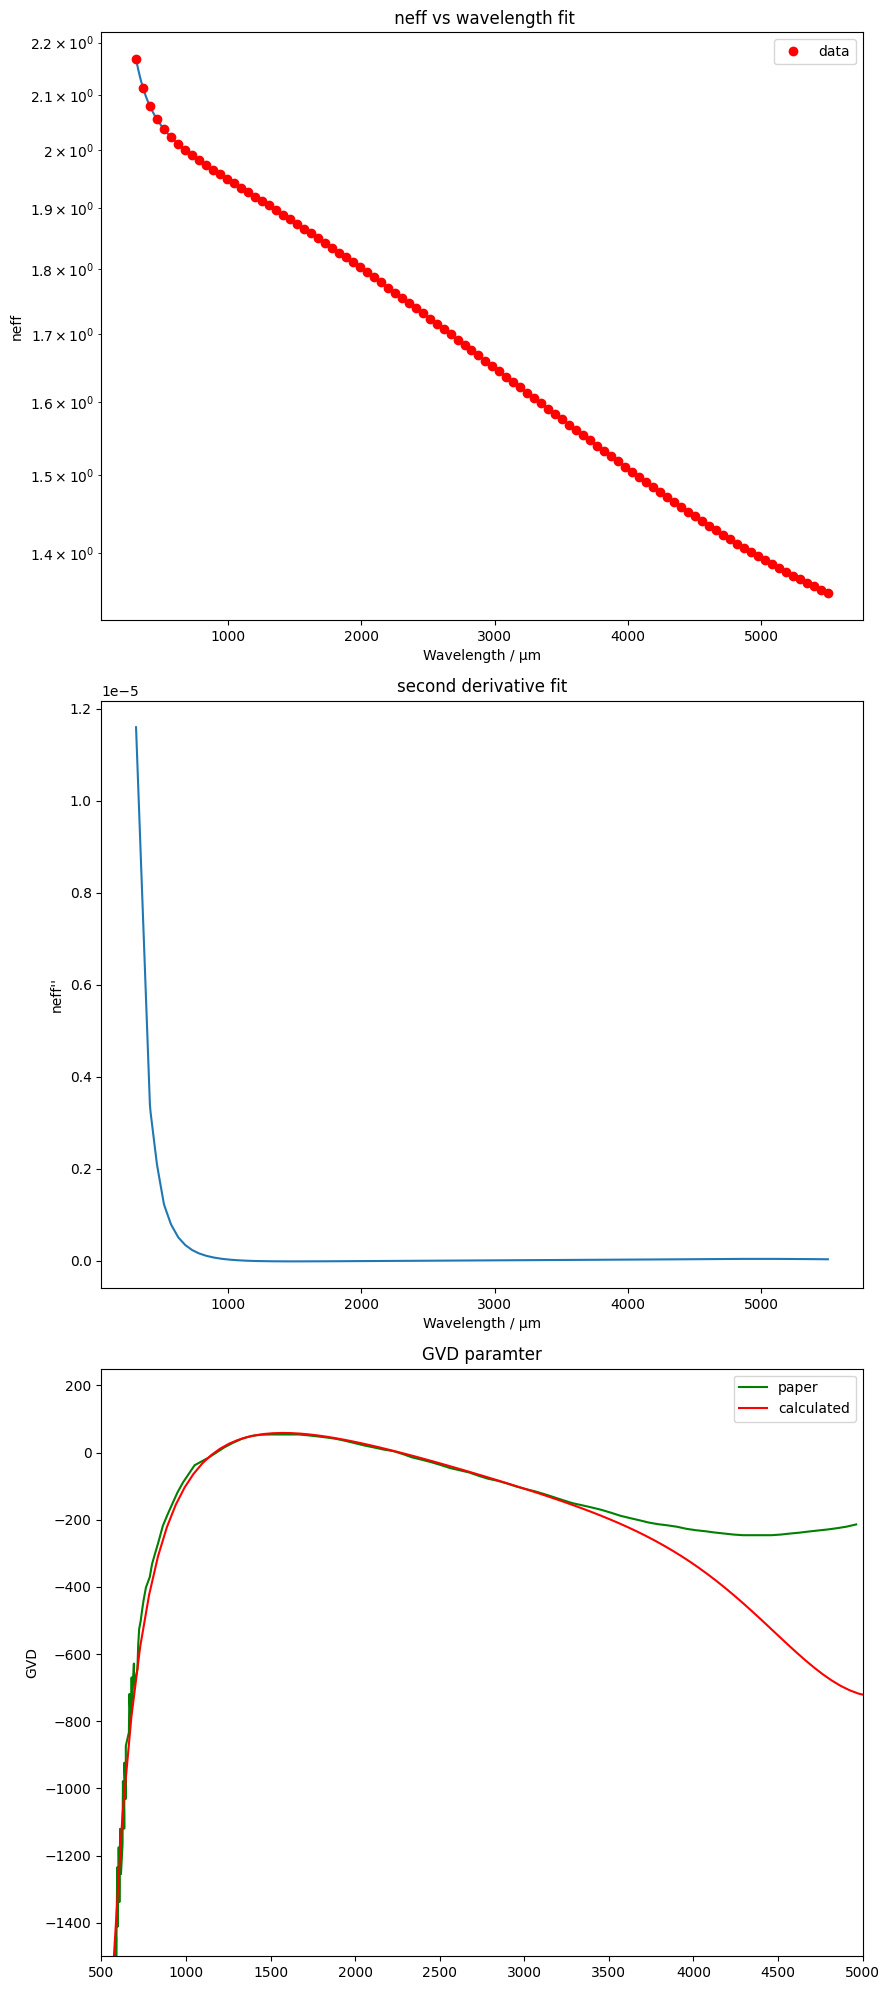

"\nplt.semilogy(wls,neff_list,'ro',label = 'data')\nx_range = np.linspace(wls[0],wls[-1],1000)\nplt.semilogy(x_range,y_spl(x_range))\n\nplt.legend()\nplt.tight_layout()\nplt.show()\n\n"

In [2]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
import pandas as pd
from scipy.constants import speed_of_light

width = 6  # um
height = 0.8  # um

data = np.load(f"data_h_{height}_w_{width}.npz")
neff_list = np.array(np.real(data['neff_list']))
wls = data['wls']
fig, axs = plt.subplots(3, 1, figsize=(9, 20))

y_spl = UnivariateSpline(wls, neff_list, s=0, k=3)
x_range = np.linspace(wls[0], wls[-1], 1000)
print(y_spl(1000))

axs[0].set_xlabel("Wavelength / µm")
axs[0].set_ylabel("neff")
axs[0].set_title(" neff vs wavelength fit")
axs[0].semilogy(x_range, y_spl(x_range))
axs[0].semilogy(wls, neff_list, 'ro', label='data')
axs[0].legend()

y_spl_2d = y_spl.derivative(n=2)
axs[1].set_xlabel("Wavelength / µm")
axs[1].set_ylabel("neff''")
axs[1].set_title("second derivative fit")
axs[1].plot(x_range, y_spl_2d(x_range))

ref_gvd = pd.read_csv("../reference_data/GVD.csv", dtype=np.float64)
ref_gvd_x, ref_gvd_y = np.split(ref_gvd.values, 2, axis=1)
axs[2].plot(ref_gvd_x, ref_gvd_y, c="green", label="paper")

GVD = (-wls / (2.99792e-7) * y_spl_2d(wls))
axs[2].plot(wls, GVD, label="calculated", c="red")

axs[2].set_ylabel("GVD")
axs[2].set_ylim(-1500, 250)
axs[2].set_xlim(500, 5000)
axs[2].set_title("GVD paramter")
axs[2].legend()

plt.tight_layout()
plt.show()

'''
plt.semilogy(wls,neff_list,'ro',label = 'data')
x_range = np.linspace(wls[0],wls[-1],1000)
plt.semilogy(x_range,y_spl(x_range))

plt.legend()
plt.tight_layout()
plt.show()

'''


Use laserfun to reproduce the spectrum of Fig 5d)


1.6057008839940752e-07
   1.0% - 1.010e-04 m - 0.0 seconds
   2.0% - 2.020e-04 m - 0.0 seconds
   3.0% - 3.030e-04 m - 0.0 seconds
   4.0% - 4.040e-04 m - 0.0 seconds
   5.1% - 5.051e-04 m - 0.0 seconds
   6.1% - 6.061e-04 m - 0.0 seconds
   7.1% - 7.071e-04 m - 0.0 seconds
   8.1% - 8.081e-04 m - 0.0 seconds
   9.1% - 9.091e-04 m - 0.0 seconds
  10.1% - 1.010e-03 m - 0.1 seconds
  11.1% - 1.111e-03 m - 0.1 seconds
  12.1% - 1.212e-03 m - 0.1 seconds
  13.1% - 1.313e-03 m - 0.1 seconds
  14.1% - 1.414e-03 m - 0.1 seconds
  15.2% - 1.515e-03 m - 0.1 seconds
  16.2% - 1.616e-03 m - 0.1 seconds
  17.2% - 1.717e-03 m - 0.1 seconds
  18.2% - 1.818e-03 m - 0.1 seconds
  19.2% - 1.919e-03 m - 0.1 seconds
  20.2% - 2.020e-03 m - 0.2 seconds
  21.2% - 2.121e-03 m - 0.2 seconds
  22.2% - 2.222e-03 m - 0.2 seconds
  23.2% - 2.323e-03 m - 0.2 seconds
  24.2% - 2.424e-03 m - 0.3 seconds
  25.3% - 2.525e-03 m - 0.5 seconds
  26.3% - 2.626e-03 m - 0.6 seconds
  27.3% - 2.727e-03 m - 0.8 seconds
  28.

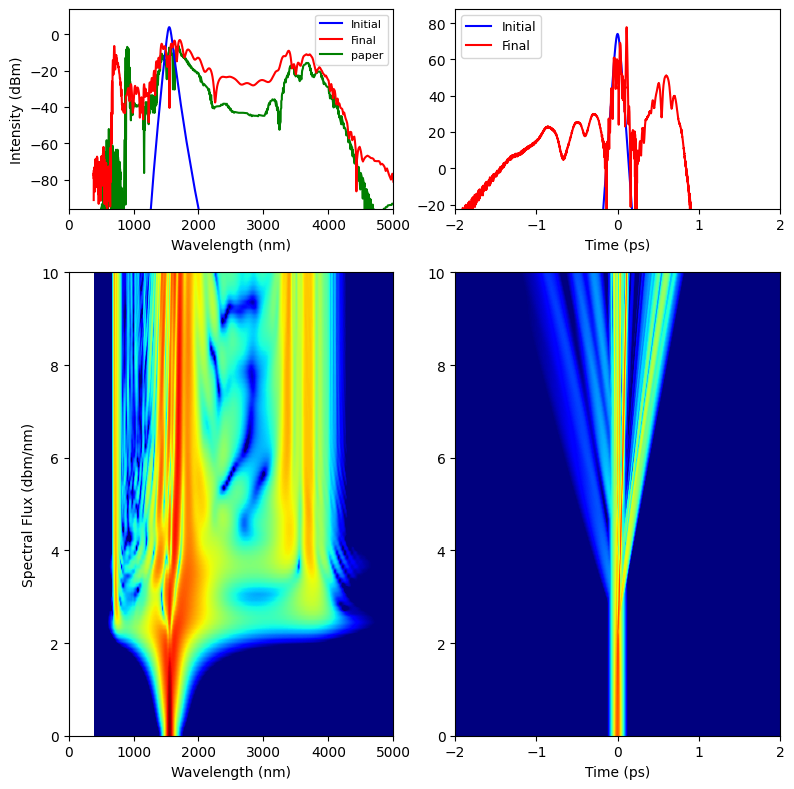

In [4]:

import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

# pulse parameters
FWHM = 50 * 1e-3  # pulse duration (ps)
pulseWL = 1550  # pulse central wavelength (nm)

power = 5000  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion

# simulation parameters
Window = 4  # simulation window (ps)
Steps = 100  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4  # absolute error
Raman = False  # Enable Raman effect?
Steep = True  # Enable self steepening?

# ----------- Build Waveguide -----------
n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

data = np.load("data_h_0.8_w_6.npz")
wls = data['wls']
neff_list = data['neff_list']
aeff_list = data['aeff_list']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma


# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=False, wav=wls, power=power, RI=neff_list, GDD=GDD, TOD=TOD, FOD=FOD,
             npts=Points)

# create the waveguide
f = lf.Fiber(10 * 1e-3, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(pulseWL), loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
###
ref_fig5d = pd.read_csv(
    "../reference_data/fig5d.csv", dtype=np.float64
)

fig, axes = results.plot(wavelength=True, show=False, tlim=(-2, 2), flim=(0, 6000))
ref_fig5d_x, ref_fig5d_y = np.split(ref_fig5d.values, 2, axis=1)

axes[0][0].plot(ref_fig5d_x, ref_fig5d_y, c="green", label="paper", zorder=0)
axes[0][0].legend(loc="upper right", fontsize=8)

axes[1][0].set_xlim(0, 5000)
plt.set_cmap('jet')
plt.show()


Problem
- Selecting mode: How to select mode of interest - using te/tm fraction? overlap coefficent?
- Selecting equations to calculate effective mode area
- Optimizing the function: select appropiate resolution, equation, wavelength steps and stimulation parameters
- SiO2 cladding and burried oxide

Guess for the accuracy: gamma varies across the waveguide?